### Strain plots + CoM overlay (DENOISED ONLY)

This notebook:

- Loads the **BabyUNet denoised stack** into RAM (eager).
- Reproduces the key **strain ROI workflow** from `strain_babyUnet.ipynb` (crop → polygon masks → q-space moments → strain maps).
- Computes the **Evaluate-style pixel CoM overlay map** for the **cropped detector region**.

Notes:
- Your denoised stack is `(141, 121, 512, 512)`. One float32 stack is ~16.7 GB.
- This is intended to run on the 48 GB machine.



In [5]:
import os
from pathlib import Path

import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.patches as patches

from matplotlib.path import Path as MplPath



In [6]:
# -----------------
# Paths (keep the same names as in `strain_babyUnet.ipynb`)
# -----------------

# Denoised babyunet stack (your original notebook uses this)
data_path_babyunet = "data/denoised_100epochs_babyunet.h5"

# Raw scan file (needed for q-grid). Your original notebook uses this.
# It must exist on the machine you run this notebook on.
data_path = "data/000278.h5"

# NOTE: This notebook is **denoised-only**. We do NOT load ORIGINAL detector frames.


def resolve_path(p: str | None) -> str | None:
    """Keep your original path strings, but fall back to known local outputs if needed."""
    if p is None:
        return None

    # 1) as-is
    if os.path.exists(p):
        return p

    # 2) common fallbacks inside this repo snapshot
    fallbacks = {
        "data/denoised_100epochs_babyunet.h5": "babyUnet_100/denoised_100epochs_babyunet.h5",
        "data/denoised_100epochs_dncnn.h5": "cnn_100/denoised_100epochs_dncnn.h5",
        "data/denoised_100epochs_unet.h5": "unet_100/denoised_100epochs_unet.h5",
        "data/denoised_unet_100.h5": "unet_100/denoised_unet_100.h5",
    }
    if p in fallbacks and os.path.exists(fallbacks[p]):
        return fallbacks[p]

    return p


DENOISED_H5_PATH = resolve_path(data_path_babyunet)
SCAN_H5_PATH = resolve_path(data_path)

print("DENOISED_H5_PATH:", DENOISED_H5_PATH, "exists:", (DENOISED_H5_PATH is not None and os.path.exists(DENOISED_H5_PATH)))
print("SCAN_H5_PATH:", SCAN_H5_PATH, "exists:", (SCAN_H5_PATH is not None and os.path.exists(SCAN_H5_PATH)))



DENOISED_H5_PATH: data/denoised_100epochs_babyunet.h5 exists: True
SCAN_H5_PATH: data/000278.h5 exists: True


In [7]:
# -----------------
# Eager load H5 stacks
# -----------------

H5_KEY_CANDIDATES = ["data", "/data", "X", "/X", "img", "/img"]

# Your original strain notebook applies an inverse Anscombe-like transform
APPLY_INVERSE_SIMPLE = True

# Hot pixel cleaning threshold (copied from `strain_babyUnet.ipynb`)
HOTPIX_THR = 2e2


def get_dset(f: h5py.File) -> h5py.Dataset:
    for k in H5_KEY_CANDIDATES:
        if k in f:
            return f[k]
    raise KeyError(f"Could not find dataset key. Root keys: {list(f.keys())}")


def estimate_gb(shape: tuple[int, ...], dtype=np.float32) -> float:
    n = 1
    for s in shape:
        n *= int(s)
    return (n * np.dtype(dtype).itemsize) / (1024**3)


def load_h5_stack(path: str) -> np.ndarray:
    with h5py.File(path, "r") as f:
        d = get_dset(f)
        print("Loading:", path)
        print("  dataset:", d.name, "shape:", tuple(int(x) for x in d.shape), "dtype:", d.dtype)
        print("  est float32 GB:", f"{estimate_gb(tuple(int(x) for x in d.shape), np.float32):.2f}")
        return np.asarray(d[...], dtype=np.float32)


def inverse_simple_inplace(y: np.ndarray) -> np.ndarray:
    """Inverse used in `strain_babyUnet.ipynb`, but done IN-PLACE to avoid a 2nd 16.7 GiB allocation.

    Computes: y <- max(y^2 - 0.375, 0)
    """
    y = y.astype(np.float32, copy=False)
    np.square(y, out=y)
    y -= np.float32(0.375)
    np.maximum(y, 0.0, out=y)
    return y


if DENOISED_H5_PATH is None or (not os.path.exists(DENOISED_H5_PATH)):
    raise FileNotFoundError(f"Denoised H5 not found: {DENOISED_H5_PATH}")

den_raw = load_h5_stack(DENOISED_H5_PATH)

print("\nLoaded arrays")
print("  den_raw:", den_raw.shape, den_raw.dtype)



Loading: data/denoised_100epochs_babyunet.h5
  dataset: /data shape: (141, 121, 512, 512) dtype: float32
  est float32 GB: 16.66

Loaded arrays
  den_raw: (141, 121, 512, 512) float32


den4: (141, 121, 512, 512) float32


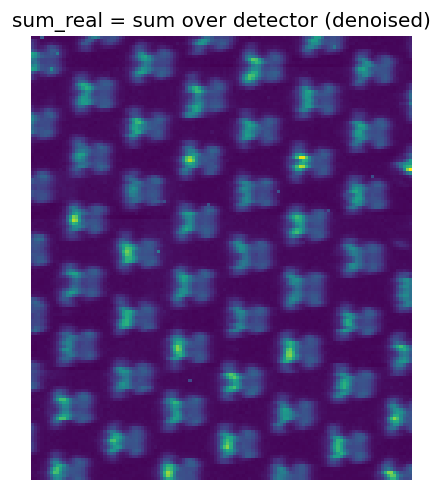

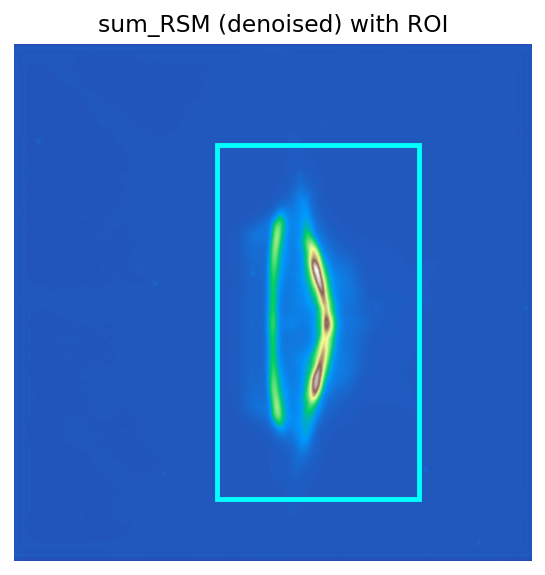

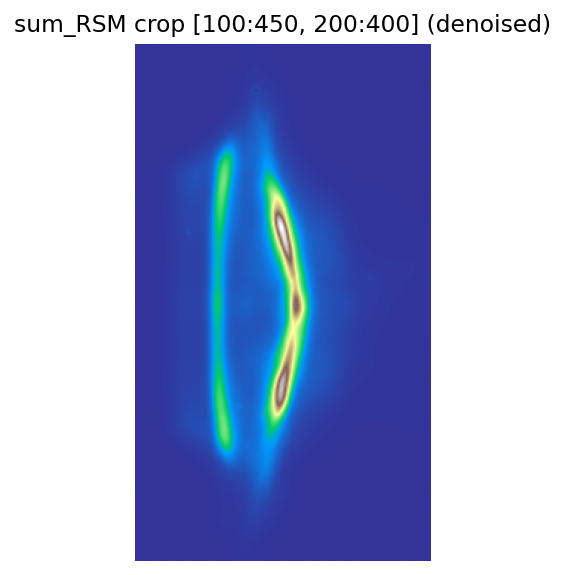

In [8]:
# -----------------
# Strain workflow (ported + simplified from `strain_babyUnet.ipynb`)
# -----------------

# The strain notebook expects a 4D stack shaped (141, 121, 512, 512).
# Support both:
# - (sy,sx,H,W)
# - (sy*sx,H,W)

def to_4d_stack(x: np.ndarray, sy: int = 141, sx: int = 121) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 4:
        return x
    if x.ndim == 3:
        b, h, w = x.shape
        if b != (sy * sx):
            raise ValueError(f"Cannot reshape: got {x.shape}, expected first dim {sy*sx}")
        return np.reshape(x, (sy, sx, h, w))
    raise ValueError(f"Expected 3D or 4D array, got ndim={x.ndim}")


# Apply inverse transform if requested (IN-PLACE to avoid doubling RAM)
den = den_raw  # alias
if APPLY_INVERSE_SIMPLE:
    den = inverse_simple_inplace(den)

# Reshape to 4D (sy,sx,H,W)
den4 = to_4d_stack(den, sy=141, sx=121)

# Hot pixel cleaning (in-place; do NOT copy the whole stack)
den4[den4 > HOTPIX_THR] = 0.0

# Drop the extra name to the same big array
import gc
try:
    del den_raw
except NameError:
    pass
gc.collect()

sy, sx, dety, detx = (int(x) for x in den4.shape)
print("den4:", den4.shape, den4.dtype)

# Sum maps (same idea as your notebook)
sum_real = den4.sum(axis=(2, 3), dtype=np.float64).astype(np.float32)  # (sy,sx)
sum_RSM = den4.sum(axis=(0, 1), dtype=np.float64).astype(np.float32)  # (dety,detx)

plt.figure(dpi=120)
plt.imshow(sum_real)
plt.axis("off")
plt.title("sum_real = sum over detector (denoised)")
plt.show()

# Consistent detector crop used everywhere
ROI_Y1, ROI_Y2 = 100, 450
ROI_X1, ROI_X2 = 200, 400

# Show full sum_RSM with ROI box overlay (axis-free)
fig, ax = plt.subplots(dpi=140)
ax.imshow(sum_RSM, cmap="terrain")
ax.add_patch(
    patches.Rectangle(
        (ROI_X1, ROI_Y1),
        ROI_X2 - ROI_X1,
        ROI_Y2 - ROI_Y1,
        fill=False,
        edgecolor="cyan",
        linewidth=2.5,
    )
)
ax.axis("off")
ax.set_title("sum_RSM (denoised) with ROI")
plt.show()

# Also show the cropped sum_RSM alone (axis-free)
plt.figure(dpi=140)
plt.imshow(sum_RSM[ROI_Y1:ROI_Y2, ROI_X1:ROI_X2], cmap="terrain")
plt.axis("off")
plt.title("sum_RSM crop [100:450, 200:400] (denoised)")
plt.show()



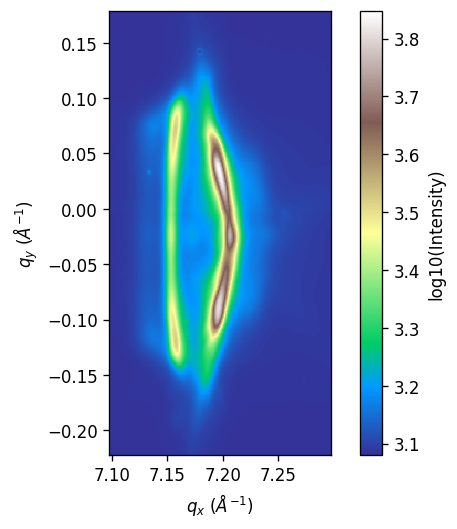

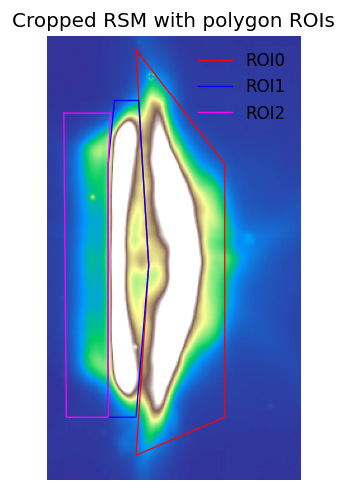

Masks: (350, 200) bool


In [9]:
# -----------------
# q-grid + ROI selection (ported from `strain_babyUnet.ipynb`)
# -----------------


def get_q_2D(scan_h5: str) -> np.ndarray:
    """Copied from `strain_babyUnet.ipynb` (with minimal cleanup)."""
    with h5py.File(scan_h5, "r") as h5:
        energy = h5["entry/snapshots/pre_scan/energy"][:]  # eV
        theta = h5["entry/snapshots/pre_scan/gamma"][:] / 2
        radius = h5["entry/snapshots/pre_scan/radius"][:] * 1e-3  # mm -> m
        npixels = np.shape(h5["entry/measurement/eiger500k/frames"])[1:]

    pixel_size = 75e-6  # m
    h, speed, ev_to_j = 6.62e-34, 2.99e8, 1.60e-19
    wavelength = h * speed / (ev_to_j * energy)

    sintheta = np.sin(np.deg2rad(theta))
    costheta = np.cos(np.deg2rad(theta))
    k = 2 * np.pi / wavelength
    G = 2 * k * sintheta

    dq12 = k * pixel_size / radius
    q1 = np.linspace(dq12 * npixels[0] / 2, -dq12 * npixels[0] / 2, npixels[0], -1)
    q2 = np.linspace(-dq12 * npixels[1] / 2 + G / costheta, dq12 * npixels[1] / 2 + G / costheta, npixels[1])

    Q1, Q2 = np.meshgrid(q1, q2, indexing="ij")
    Qv = Q1
    Qh = Q2 * costheta

    q_values = np.array([Qv, Qh])
    return q_values


if SCAN_H5_PATH is None or (not os.path.exists(SCAN_H5_PATH)):
    raise FileNotFoundError(
        f"Scan H5 not found: {SCAN_H5_PATH}.\n"
        f"This notebook needs it to compute q-values (same as `strain_babyUnet.ipynb`)."
    )

q_values = get_q_2D(SCAN_H5_PATH)

# Crop ROI (consistent everywhere)
y1, y2 = 100, 450
x1, x2 = 200, 400

# Optional sanity check: ensure this matches the ROI overlay
assert (y1, y2, x1, x2) == (ROI_Y1, ROI_Y2, ROI_X1, ROI_X2)

# NOTE: ORIGINAL loading removed (denoised-only notebook)

cropped_RSM = sum_RSM[y1:y2, x1:x2]
Q_ROI = q_values[:, y1:y2, x1:x2] * 1e-10

fig, ax = plt.subplots(dpi=120)
RSM = ax.pcolormesh(Q_ROI[1], Q_ROI[0], np.log10(np.clip(cropped_RSM, 1e-12, None)), cmap="terrain")
ax.axes.set_aspect("equal", "box")
ax.set_ylabel(r"$q_y \ (\AA^{-1})$")
ax.set_xlabel(r"$q_x \ (\AA^{-1})$")
fig.colorbar(RSM, ax=ax, label="log10(Intensity)")
plt.show()


def polygon_roi(coords: list[list[float]]) -> tuple[np.ndarray, np.ndarray]:
    coords = list(coords)
    coords.append(coords[0])
    xs, ys = zip(*coords)
    return np.asarray(xs), np.asarray(ys)


def get_polygon_mask(image2d: np.ndarray, coords: list[list[float]]) -> np.ndarray:
    polygon = MplPath(coords)
    ny, nx = image2d.shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = polygon.contains_points(points).reshape(ny, nx)
    return mask


plt.figure(dpi=120)
plt.imshow(cropped_RSM, vmax=np.percentile(cropped_RSM, 90), cmap="terrain")

# ROI polygons (copied from your notebook)
coord_ROI0 = [[70, 10], [140, 100], [140, 300], [70, 330], [80, 180], [75, 100]]
coord_ROI1 = [[53, 50], [72, 50], [80, 180], [70, 300], [48, 300], [48, 180], [48, 100]]
coord_ROI2 = [[13, 60], [50, 60], [48, 100], [48, 180], [48, 300], [45, 300], [15, 300]]

x0, y0 = polygon_roi(coord_ROI0)
plt.plot(x0, y0, lw=0.8, color="r", label="ROI0")

x1p, y1p = polygon_roi(coord_ROI1)
plt.plot(x1p, y1p, lw=0.8, color="b", label="ROI1")

x2p, y2p = polygon_roi(coord_ROI2)
plt.plot(x2p, y2p, lw=0.8, color="magenta", label="ROI2")

plt.axis("off")
plt.legend(frameon=False)
plt.title("Cropped RSM with polygon ROIs")
plt.show()

mask_RSM0 = get_polygon_mask(cropped_RSM, coord_ROI0)
mask_RSM1 = get_polygon_mask(cropped_RSM, coord_ROI1)
mask_RSM2 = get_polygon_mask(cropped_RSM, coord_ROI2)

print("Masks:", mask_RSM0.shape, mask_RSM0.dtype)



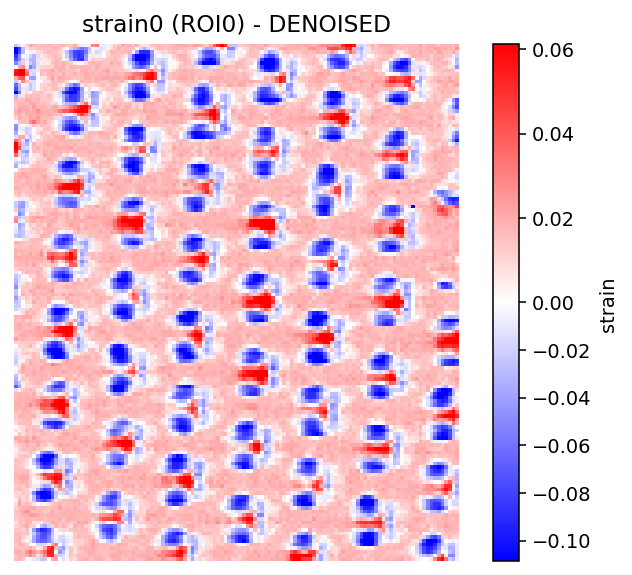

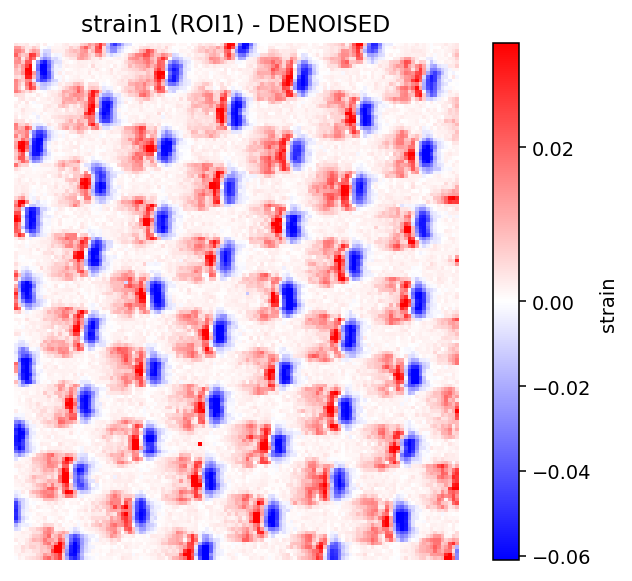

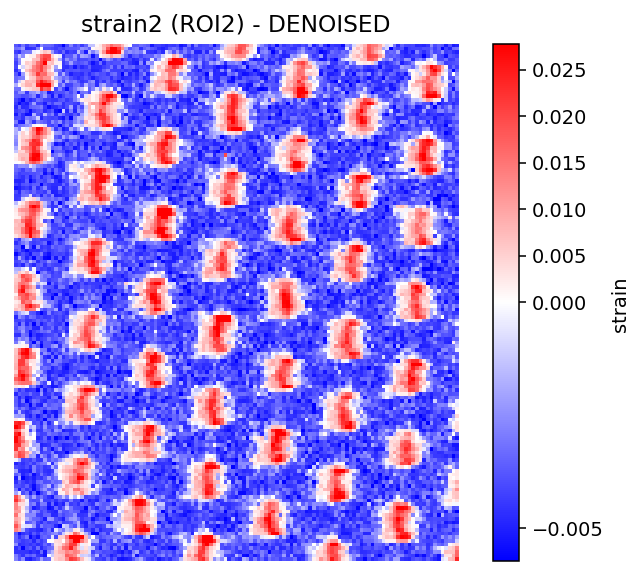

In [12]:
# -----------------
# Moments + strain maps (vectorized version of your `get_moments`)
# + side-by-side ORIGINAL vs DENOISED
# -----------------


def moments_from_roi_frame(
    frame2d: np.ndarray,
    Q_roi: np.ndarray,
) -> tuple[float, float, float, float]:
    """COM_x, COM_y, FWHM_x, FWHM_y for a single (h,w) ROI frame.

    This avoids multi-GB intermediates from the fully-vectorized 4D version.
    """
    x = np.asarray(frame2d, dtype=np.float64)
    x = np.clip(x, 0.0, None)

    Qx = np.asarray(Q_roi[1], dtype=np.float64)
    Qy = np.asarray(Q_roi[0], dtype=np.float64)

    tot = float(x.sum())
    if not np.isfinite(tot) or tot <= 0.0:
        return float("nan"), float("nan"), float("nan"), float("nan")

    com_x = float((x * Qx).sum() / tot)
    com_y = float((x * Qy).sum() / tot)

    var_x = float((x * (Qx - com_x) ** 2).sum() / tot)
    var_y = float((x * (Qy - com_y) ** 2).sum() / tot)

    fwhm_x = float(2 * np.sqrt(2 * np.log(2)) * np.sqrt(var_x))
    fwhm_y = float(2 * np.sqrt(2 * np.log(2)) * np.sqrt(var_y))

    return com_x, com_y, fwhm_x, fwhm_y


def strain_from_com(COM_x: np.ndarray, COM_y: np.ndarray) -> np.ndarray:
    Q_mod = np.sqrt(COM_x**2 + COM_y**2)
    ds = 2 * np.pi / Q_mod
    return 100 * (np.nanmean(ds) - ds) / np.nanmean(ds)


def compute_strain_maps(
    stack4: np.ndarray,
    *,
    max_scan_pos: int | None = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (strain0, strain1, strain2) for ROI0/1/2.

    Memory-safe implementation: loops over scan positions so we never create
    huge (sy,sx,h,w) cropped arrays.
    """
    sy, sx, _, _ = (int(v) for v in stack4.shape)

    COM_x0 = np.full((sy, sx), np.nan, dtype=np.float32)
    COM_y0 = np.full((sy, sx), np.nan, dtype=np.float32)
    COM_x1 = np.full((sy, sx), np.nan, dtype=np.float32)
    COM_y1 = np.full((sy, sx), np.nan, dtype=np.float32)
    COM_x2 = np.full((sy, sx), np.nan, dtype=np.float32)
    COM_y2 = np.full((sy, sx), np.nan, dtype=np.float32)

    # Optional quick-test limiter
    n_done = 0

    for iy in range(sy):
        for ix in range(sx):
            frame_crop = stack4[iy, ix, y1:y2, x1:x2]

            f0 = frame_crop * mask_RSM0
            f1 = frame_crop * mask_RSM1
            f2 = frame_crop * mask_RSM2

            cx0, cy0, _, _ = moments_from_roi_frame(f0, Q_ROI)
            cx1, cy1, _, _ = moments_from_roi_frame(f1, Q_ROI)
            cx2, cy2, _, _ = moments_from_roi_frame(f2, Q_ROI)

            COM_x0[iy, ix] = np.float32(cx0)
            COM_y0[iy, ix] = np.float32(cy0)
            COM_x1[iy, ix] = np.float32(cx1)
            COM_y1[iy, ix] = np.float32(cy1)
            COM_x2[iy, ix] = np.float32(cx2)
            COM_y2[iy, ix] = np.float32(cy2)

            n_done += 1
            if max_scan_pos is not None and n_done >= int(max_scan_pos):
                break
        if max_scan_pos is not None and n_done >= int(max_scan_pos):
            break

    return (
        strain_from_com(COM_x0, COM_y0),
        strain_from_com(COM_x1, COM_y1),
        strain_from_com(COM_x2, COM_y2),
    )


# DENOISED-only strain maps
# Tip: set max_scan_pos=200 for a quick sanity test on a smaller machine.
strain0_den, strain1_den, strain2_den = compute_strain_maps(den4, max_scan_pos=None)


def plot_strain(m: np.ndarray, title: str):
    vmin = np.nanpercentile(m, 1)
    vmax = np.nanpercentile(m, 99)
    plt.figure(dpi=140)
    plt.imshow(m, cmap="bwr", norm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax))
    plt.colorbar(label="strain ")
    plt.title(title)
    plt.axis("off")
    plt.show()


plot_strain(strain0_den, "strain0 (ROI0) - DENOISED")
plot_strain(strain1_den, "strain1 (ROI1) - DENOISED")
plot_strain(strain2_den, "strain2 (ROI2) - DENOISED")



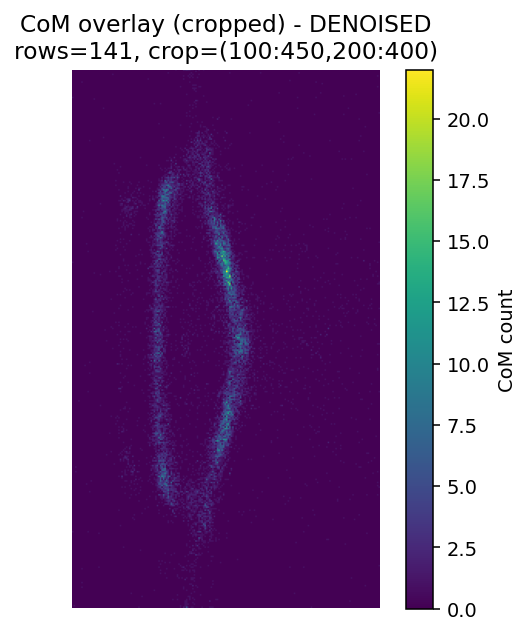

In [11]:
# -----------------
# Evaluate-style pixel CoM overlay (ported from Evaluate notebook)
# - viridis
# - computed + plotted ONLY for the cropped detector region (y1:y2, x1:x2)
# -----------------

COM_THRESH_PCT = 99.999
MAX_Y_ROWS = None  # set e.g. 20 for a quick test

# Use the same crop as the strain ROI crop
CROP_Y = slice(int(y1), int(y2))
CROP_X = slice(int(x1), int(x2))


def threshold_for_com(img: np.ndarray, pct: float = COM_THRESH_PCT) -> np.ndarray:
    x = np.asarray(img, dtype=np.float32)
    x = np.clip(x, 0.0, None)
    thr = float(np.percentile(x, float(pct)))
    x = x.copy()
    x[x < thr] = 0.0
    return x


def center_of_mass_2d(img: np.ndarray) -> tuple[float, float]:
    x = np.asarray(img, dtype=np.float64)
    x = np.clip(x, 0.0, None)
    s = float(x.sum())
    if not np.isfinite(s) or s <= 0.0:
        return float("nan"), float("nan")
    yy, xx = np.indices(x.shape)
    yc = float((yy * x).sum() / s)
    xc = float((xx * x).sum() / s)
    return yc, xc


def mark_com(m: np.ndarray, yc: float, xc: float) -> None:
    if not (np.isfinite(yc) and np.isfinite(xc)):
        return
    yi = int(np.clip(np.round(yc), 0, m.shape[0] - 1))
    xi = int(np.clip(np.round(xc), 0, m.shape[1] - 1))
    m[yi, xi] += 1.0


def com_overlay_cropped(
    stack4: np.ndarray,
    *,
    crop_y: slice,
    crop_x: slice,
    max_y_rows: int | None = None,
) -> np.ndarray:
    sy, sx, _, _ = stack4.shape
    y_do = sy if max_y_rows is None else min(int(max_y_rows), sy)

    h = int(crop_y.stop) - int(crop_y.start)
    w = int(crop_x.stop) - int(crop_x.start)

    m = np.zeros((h, w), dtype=np.float32)
    for yy in range(y_do):
        row = stack4[int(yy)]  # (sx,H,W)
        for xx in range(int(sx)):
            frame_crop = row[int(xx), crop_y, crop_x]
            yc, xc = center_of_mass_2d(threshold_for_com(frame_crop))
            mark_com(m, yc, xc)

    return m


COM_MAP_DENOISED_CROP = com_overlay_cropped(den4, crop_y=CROP_Y, crop_x=CROP_X, max_y_rows=MAX_Y_ROWS)

plt.figure(figsize=(6, 5), dpi=140)
im = plt.imshow(COM_MAP_DENOISED_CROP, cmap="viridis")
plt.title(
    f"CoM overlay (cropped) - DENOISED\n"
    f"rows={sy if MAX_Y_ROWS is None else MAX_Y_ROWS}, crop=({CROP_Y.start}:{CROP_Y.stop},{CROP_X.start}:{CROP_X.stop})"
)
plt.axis("off")
plt.colorbar(im, fraction=0.046, pad=0.04, label="CoM count")
plt.show()

